In [1]:
from ResearchMain import *
#该文件通过读取标准曲线CT值csv文件，将其绘制成标准曲线，同时把标准曲线拟合的公式保存到拟合公式文件中——fitting_formula.csv中。

In [2]:
# 绘图全局设置
sns.set_theme(style="whitegrid", font='Times New Roman', font_scale=1.5)
# data文件路径、程序输出文件路径、绘图dpi
IMG_NAME = '功能基因标准曲线图'
# 禁用科学计数法
# pd.set_option('display.float_format',lambda x : '%.2f' % x)

In [3]:
# 读取数据，标准曲线原始CT值，每个样品设置三个重复对照组
ct_df_0 = pd.read_csv(DATA_PATH + 'standard_curve_ct.csv')
ct_df = ct_df_0.copy()
ct_df

,Gene,10^,CT
0,Bacterial 16S rRNA,12,6.753226
1,Bacterial 16S rRNA,12,6.197486
2,Bacterial 16S rRNA,12,6.546994
3,Bacterial 16S rRNA,11,8.653898
4,Bacterial 16S rRNA,11,8.813245
...,...,...,...
355,nifH,3,31.050545
356,nifH,3,31.259661
357,nifH,2,33.719639
358,nifH,2,32.832277


In [4]:
# 预处理
ct_df = ct_df.dropna(how='all', axis=1)
ct_df_plot = ct_df.pivot_table(index='10^', columns='Gene', values='CT', aggfunc='mean')
ct_df_plot

Gene,AOA_amoA,AOB_amoA,Archaeal 16S rRNA,Bacterial 16S rRNA,cnorB,hzo,hzsA,hzsB,napA,narG,nifH,nirK,nirS,nosZ,nxrA
10^,,,,,,,,,,,,,,,
2,29.739663,31.406330,NaN,NaN,29.406330,40.012633,29.537068,30.636283,37.761599,32.183941,33.406330,30.533388,39.012093,36.346436,36.496626
3,26.292590,27.292590,NaN,NaN,27.292590,34.404192,28.312222,26.839334,30.796565,31.292590,31.292590,28.084649,35.403671,34.367200,35.802055
4,23.580728,24.580728,NaN,NaN,24.580728,31.324250,25.620266,24.058524,28.650891,28.580728,28.580728,25.830395,32.323776,32.504540,32.487557
5,21.538671,20.538671,28.406330,32.406330,21.205338,28.626449,23.158060,21.393240,25.382507,25.205338,25.205338,21.961890,29.626016,29.705086,29.584302
6,16.564295,16.564295,26.292590,27.292590,17.564295,25.429335,20.346274,17.845301,22.039589,21.227926,22.564295,17.818998,24.762263,25.771079,25.911917
7,12.624980,12.624980,23.580728,24.580728,14.624980,20.152941,15.762296,12.921906,18.932280,17.487695,18.624980,15.281875,22.152621,21.616645,21.541642
8,9.693374,9.693374,20.205338,19.538671,11.693374,17.959160,13.414822,10.241604,15.677140,15.779348,16.693374,10.612648,18.974130,18.673536,19.180791
9,5.038920,7.372253,17.564295,16.564295,8.118687,14.707299,8.703844,8.719964,12.697195,12.657762,12.038920,9.444135,12.208105,14.188152,12.825347
10,NaN,NaN,12.624980,13.624980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
def make_fit_equ_str(paras):
    """
    拼接拟合方程
    :param paras: 传入参数为np.polyfit(X, Y, DEG)返回的对象
    :return: 返回一个拼接拟合方程的字符串(LaTex格式)
    """

    fit_equ_str = ''
    # 遍历拟合后的常数项，例如常数项是：[2, 3, -4]，需要转化成：2x^2+3x-4

    for i in range(len(paras)):
        # 遍历常数项的过程中，主要需要进行两步“组装”：①如果该常数项不是第一个常数项，且该常数项大于0，需要转化为字符串并在前面添加一个“+”；
        if paras[i]:  # 如果常数项不为0(为0直接跳过这一项)
            cur_item = str(round(paras[i], 4))  # 每个常数项都保留两位小数，并转化为字符串
            # 如果不是第一个常数项，且该常数项大于0，需要转化为字符串前面添加一个“+”
            if paras[i] > 0 and fit_equ_str != '':  # 注意两种特殊情况：[0, 0, -5, 7]、[0, -5, 7]如何排除
                cur_item = '+' + cur_item

            # ②为每一个常数项添加x的幂指数
            if i == (len(paras) - 1) and cur_item != '0':  # 最后一个项只有一个常数，不需要添加x了（如果为0就不用+了）
                fit_equ_str += cur_item
            else:  # 前面的每一项都需要在最后加上一个x^幂数
                idempotent_num = len(paras) - 1 - i  # 对应的幂指数
                if idempotent_num == 1:  # 拟合为一次多项式
                    fit_equ_str += cur_item + 'x'
                else:  # 拟合为二次及二次以上的多项式
                    fit_equ_str += cur_item + 'x^' + str(idempotent_num)  #方程拼接

    # fit_equ_str = '$' + fit_equ_str + '$'  # 将多项式转化为LaTex公式
    return fit_equ_str


# make_fit_equ_str([1, 0, 2, 1])

def check_amp_eff(gene_name: str, k: float):
    """
    计算扩增效率E，合格范围在85~110%。
    :param gene_name: 基因名称，如果E不合格，需要输出提示
    :param k: 标准曲线的斜率
    :return: e：扩增效率
    """
    e = 10 ** (-1 / k) - 1
    if not 0.85 <= e <= 1.1:
        hues.warn(f'基因【{gene_name}】的扩增效率为【{e}】，不满足要求！')
    e = format(e, '.2%').replace('%', '\%')
    return e

# check_amp_eff('demo', 0.81)

In [6]:
# 选择制作每个基因标准曲线的拟合点：一般来说10-1～10-8做标曲是可以做出趋势的，经过多次实验，一般跑qPCR会用10-2～10-9八个值，从中间最少挑取连续的5个点做标曲，只要R＞0.99就可以，就是没有把其他的没用的值去掉
fitting_point_gene = {
    'Bacterial 16S rRNA': [5, 11],
    'Archaeal 16S rRNA': [6, 11],
    'AOA_amoA': [3, 9],
    'AOB_amoA': [3, 9],
    'nxrA': [3, 8],
    'narG': [3, 9],
    'napA': [3, 9],
    'nirK': [3, 8],
    'nirS': [4, 8],
    'nosZ': [3, 8],
    'cnorB': [2, 9],
    'hzsA': [3, 9],
    'hzsB': [2, 7],
    'hzo': [3, 9],
    'nifH': [3, 9]
}

for item in fitting_point_gene.items():
    fitting_point_gene[item[0]] = [i for i in range(item[1][0], item[1][1] + 1)]

# fitting_point_gene

In [7]:
# 调整列顺序
ct_df_plot = ct_df_plot[list(fitting_point_gene.keys())]

16:53:24 - WARNING - 基因【Bacterial 16S rRNA】的扩增效率为【0.8320368359893295】，不满足要求！
16:53:24 - WARNING - 基因【napA】的扩增效率为【1.1036244612032764】，不满足要求！
16:53:24 - WARNING - 基因【cnorB】的扩增效率为【1.101041804864277】，不满足要求！


<Figure size 1800x1200 with 0 Axes>

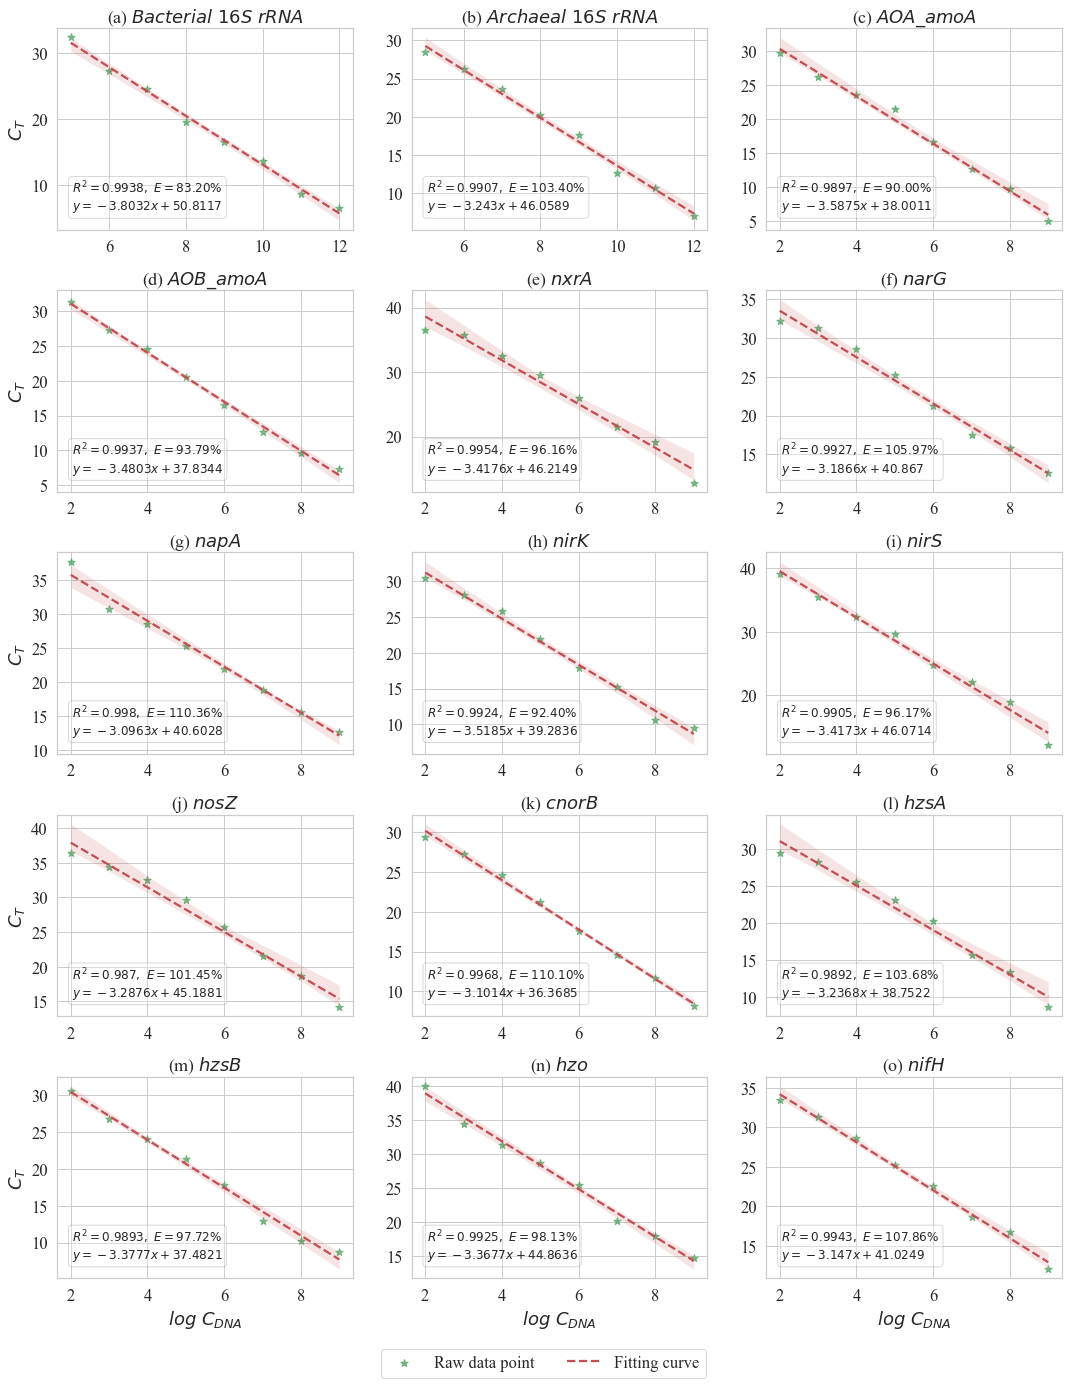

In [9]:
# 绘制标准曲线
plt.figure(dpi=DPI)
fig, ax_arr = plt.subplots(ROW_NUM, COL_NUM, figsize=(18, 23))  # sharex、y设置子图共享x、y轴坐标
fig.subplots_adjust(hspace=0.3, wspace=0.2)  # 设置子图的横纵间距
# 存放拟合公式(一元一次，k：斜率，b：截距)的df
fitting_formula = pd.DataFrame(index=['k', 'b'])
# 绘图
X = ct_df_plot.index
for index, s in enumerate(ct_df_plot.iteritems()):
    gene, Y = s[0], s[1]  # [fitting_point[s[0]]]
    # 拟合数据的点并不是所有做标线的点，从中挑选至少5个连续的点即可
    fitting_point = Y[fitting_point_gene[s[0]]]
    x_fitting, y_fitting = fitting_point.index, fitting_point
    para_list = np.polyfit(x_fitting, y_fitting, 1)  #获取拟合多项式的常数项
    # 拟合结果存放至df中，循环收集完毕进行保存为csv文件
    fitting_formula[gene] = para_list
    # 根据拟合结果计算R^2
    fit_equ = np.poly1d(para_list)  # 根据拟合后返回的常数项组建一个拟合方程
    R_2 = np.corrcoef(y_fitting, fit_equ(x_fitting))[0, 1] ** 2
    # 计算扩增效率
    E = check_amp_eff(gene_name=gene, k=para_list[0])
    # 计算当前图形行列号
    row_num = index // 3
    col_num = index - row_num * 3
    current_item = sns.regplot(x=X, y=Y,
                               # data=data,
                               color='#000000',
                               marker='*',
                               scatter_kws={'s': 60, 'color': 'g', },  #设置散点属性，参考plt.scatter
                               line_kws={'linestyle': '--', 'color': 'r'},  #设置线属性，参考 plt.plot
                               ax=ax_arr[row_num][col_num]
                               )
    current_item.text(x=0.05, y=0.1,  #文本x、y轴坐标
                      s=f'$R^2={round(R_2, 4)},\ E={E}$' + '\n' + f'$y={make_fit_equ_str(para_list)}$',  #文本内容
                      fontdict=dict(fontsize=12),  #字体属性字典
                      bbox={  #添加文字背景色
                          'facecolor': 'white',  #填充色
                          'edgecolor': 'gray',  #外框色
                          'alpha': 0.3,  #框透明度
                          # 'pad': 8,  #本文与框周围距离
                          'boxstyle': 'round'
                      },
                      transform=current_item.transAxes)

    # 子图名称
    gene = gene.replace(' ', '\\ ').replace('_', '\\_')  # 对基因名称中的空格和下划线进行转义处理
    current_item.set_title(f'({CHAR[index]}) ' + '$' + gene + '$')
    # 子图x轴名称(只保留最后一行)
    if len(ct_df_plot.columns) - (index + 1) < 3:
        current_item.set_xlabel('$log\ C_{DNA}$')
    else:
        current_item.set_xlabel(None)
    # 子图x轴名称(除去每行第2~最后的子图的y轴名称)
    if (index + 1) % COL_NUM != 1:
        current_item.set_ylabel(None)
    else:
        current_item.set_ylabel('$C_T$')

# 添加图例
fig.legend(['Raw data point', 'Fitting curve'], loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0.06))
# 保存图片
fig.savefig(EXPORT_PATH + IMG_NAME + IMG_TYPE, dpi=DPI, bbox_inches='tight')